# Project_X

## Шаг 0. Первый блин комом
**Изначально мы использовали два датасета, которые соединили, подготовили к работе и т.д., но потом поняли, что после этих манипуляций у нас осталось только 226 фильмов, что указывало на то, что нехватка данных может стать главной проблемой при машинном обучении. Поэтому было принято решение менять исходный датасет.**

## Шаг 1. Выбор датасета
**Для нашего проекта мы выбрали датасет с 10000 фильмам, за которые проголосовало больше всего человек на сайте IMDb**

Название датасета на kaggle - IMDB 10,000 Most Voted Feature Films (04/11/18)

**Переменные из исходного датасета**
* `Rank` - ранг(место) фильма в датасете
* `Title` - название фильма
* `Year` - год выпуска фильма
* `Score` - рейтинг IMDb, то есть рейтинг на основе оценок зарегистрированных пользователей сайта IMDb
* `Metascore` - рейтинг от кинокритиков
* `Genre` - жанры фильма
* `Vote` - количество оценок зарегистрированных пользователей сайта IMDb
* `Director` - режиссер
* `Runtime` - длительность фильма
* `Revenue` - прибыль, полученная от фильма
* `Description` - краткое описание фильма

In [1]:
import numpy as np         
import pandas as pd        
from scipy import stats  
import scipy.stats as sts
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("movies.csv")
df.head()

,Rank,Title,Year,Score,Metascore,Genre,Vote,Director,Runtime,Revenue,Description
0,1,The Shawshank Redemption,1994,9.3,80.0,Drama,2011509,Frank Darabont,142,28.34,Two imprisoned men bond over a number of years...
1,2,The Dark Knight,2008,9.0,84.0,"Action, Crime, Drama",1980200,Christopher Nolan,152,534.86,When the menace known as the Joker emerges fro...
2,3,Inception,2010,8.8,74.0,"Action, Adventure, Sci-Fi",1760209,Christopher Nolan,148,292.58,A thief who steals corporate secrets through t...
3,4,Fight Club,1999,8.8,66.0,Drama,1609459,David Fincher,139,37.03,An insomniac office worker and a devil-may-car...
4,5,Pulp Fiction,1994,8.9,94.0,"Crime, Drama",1570194,Quentin Tarantino,154,107.93,"The lives of two mob hitmen, a boxer, a gangst..."


## Шаг 2. EDA

Сразу смотрим на количество пропусков

In [3]:
df.isnull().sum()

Rank              0
Title             0
Year              0
Score             0
Metascore      3219
Genre             0
Vote              0
Director          1
Runtime           0
Revenue        2527
Description       0
dtype: int64

Пропуски есть в двух колонках: Metascore - оценка от критиков и Revenue - прибыль от фильма. Мы считаем, что нужно их дропнуть, а не заполнить средними значениями, по двум причинам:
1. У этих переменных уникальные значения
2. Даже если дропнем их, то выборка будет достаточно большой и не возникнет проблемы с нехваткой данных в выборке

In [4]:
df=df.dropna()
df.isnull().sum()

Rank           0
Title          0
Year           0
Score          0
Metascore      0
Genre          0
Vote           0
Director       0
Runtime        0
Revenue        0
Description    0
dtype: int64

Также дропаем переменные, которые нам не пригодятся при дальнейшей работе:
* `Description` - краткое описание фильма - слишком много букв, мы больше любим цифры
* `Rank` - ранг(место) фильма в датасете - циферки, но неинтересные, тоже не пригодятся
* `Director` - режиссер - опять текст, а любим цифры
* `Title` - название фильма - не опять, а снова

In [5]:
df.drop('Description', axis=1, inplace=True)
df.drop('Rank', axis=1, inplace=True)
df.drop('Director', axis=1, inplace=True)
df.drop('Title', axis=1, inplace=True)
df.head()

,Year,Score,Metascore,Genre,Vote,Runtime,Revenue
0,1994,9.3,80.0,Drama,2011509,142,28.34
1,2008,9.0,84.0,"Action, Crime, Drama",1980200,152,534.86
2,2010,8.8,74.0,"Action, Adventure, Sci-Fi",1760209,148,292.58
3,1999,8.8,66.0,Drama,1609459,139,37.03
4,1994,8.9,94.0,"Crime, Drama",1570194,154,107.93


Теперь посмотрим на то, какие переменные остались

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6125 entries, 0 to 9991
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Year       6125 non-null   int64  
 1   Score      6125 non-null   float64
 2   Metascore  6125 non-null   float64
 3   Genre      6125 non-null   object 
 4   Vote       6125 non-null   int64  
 5   Runtime    6125 non-null   int64  
 6   Revenue    6125 non-null   float64
dtypes: float64(3), int64(3), object(1)
memory usage: 382.8+ KB


**Переменные, которые будут использоваться при дальнейшей работе:**

* `Year` - год выпуска фильма
* `Score` - рейтинг IMDb, то есть рейтинг на основе оценок зарегистрированных пользователей сайта IMDb, от 0 до 10
* `Metascore` - рейтинг от кинокритиков, от 0 до 100
* `Genre` - жанры фильма, записываются через запятую, если у фильма больше одного жанра
* `Vote` - количество оценок зарегистрированных пользователей сайта IMDb
* `Runtime` - длительность фильма в минутах
* `Revenue` - прибыль, полученная от фильма, в миллионах долларов

Составим список из категориальных переменных и список из действительных переменных, а также обозначим целевой признак. 
В нашем случае целевой признак - рейтинг от пользователей IMDb

In [7]:
var_cat = ['Genre']

var_real = ['Metascore', 'Vote', 'Runtime', 'Revenue', 'Year']

target = 'Score'

## Шаг 3. Визуализации(ура!!!)

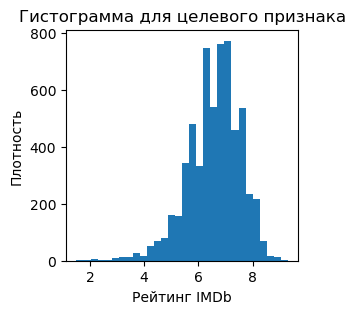

In [8]:
plt.figure(figsize=(3, 3))
plt.hist(df[target], bins=30)
plt.xlabel('Рейтинг IMDb')
plt.ylabel('Плотность')
plt.title('Гистограмма для целевого признака')
plt.show()

На данном графике изображено распределение целевого признака - 'Score'. Можно заметить, что у распределения длинный левый хвост, что говорит о том, что в датасете с фильмами, за которые проголосовало больше всего человек на сайте IMDb, не так много фильмов с оценками ниже 5. Довольно ожидаемо, поэтому оставим все как есть.

**Гистограммы действительных переменных**

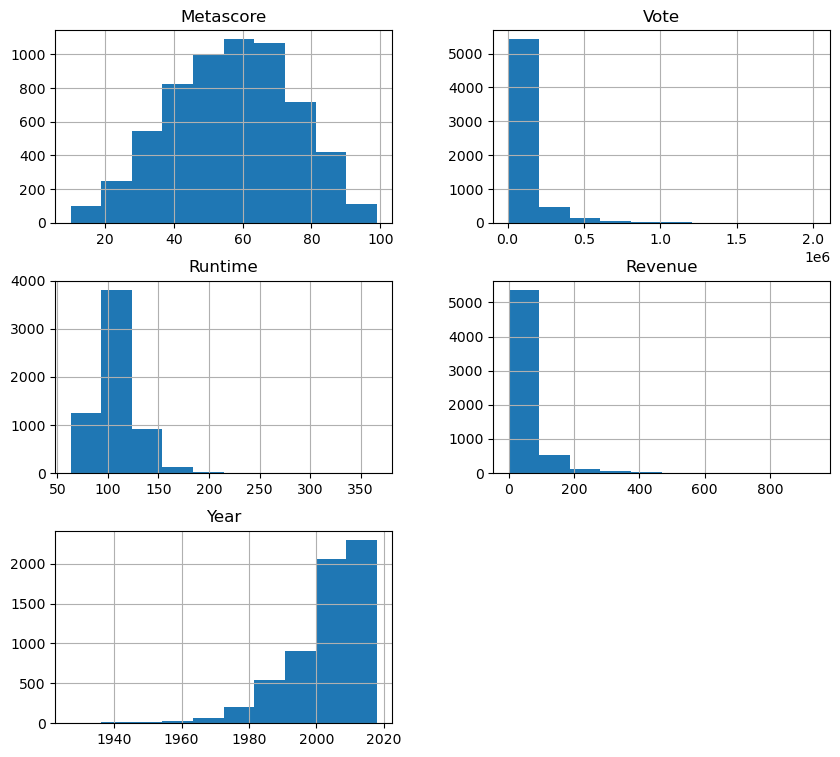

In [9]:
df[var_real].hist(figsize=( 10 , 9))
plt.show()

На графиках изображены распределения действительных переменных. Самым приятным и нормальным распределением является переменная 'Metascore'. Здесь нет выбросов, которые бросаются в глаза и которые можно было бы отсечь. Касаемо переменных 'Runtime' и 'Year', можно сказать, что с ними все в порядке, не стоит делать выводы о выбросах в этих данных, так как это года и продолжительность фильма. Тут мы можем видеть, что с годами возрастает возможность производства фильмов, раньше это было не доступно из-за нехватки нужных технологий. Такая же история с продолжительностью фильмов, мы можем сказать, что в среднем фильм длится 100 - 120 минут, некоторые больше/меньше, но это нельзя записать в выбросы.

**Нужно посмотреть на то, как переменные коррелируют с таргетом, для этого построим соответствующие облака рассеивания.**

<Axes: xlabel='Revenue', ylabel='Score'>

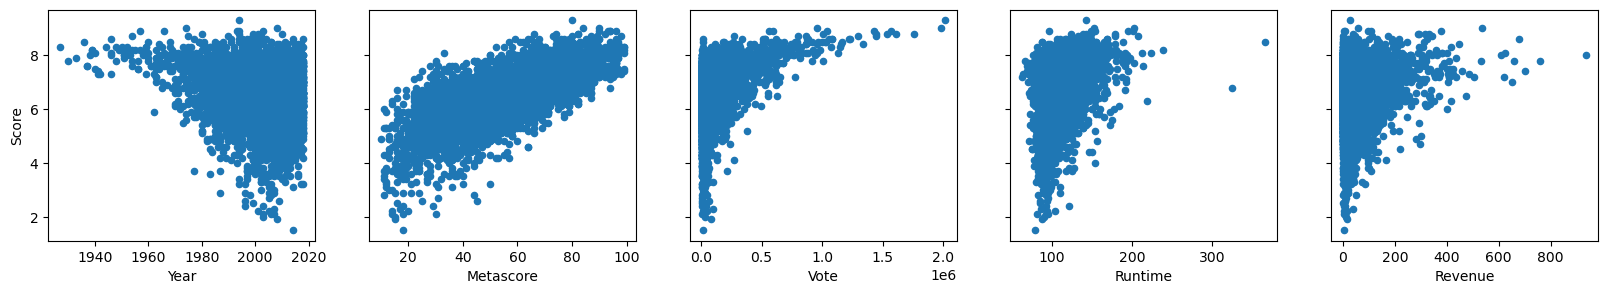

In [10]:
fig,axs=plt.subplots(1, 5, sharey=True)
df.plot(kind='scatter', x='Year', y=target, ax=axs[0], figsize=(20, 3))
df.plot(kind='scatter', x='Metascore', y=target, ax=axs[1])
df.plot(kind='scatter', x='Vote', y=target, ax=axs[2])
df.plot(kind='scatter', x='Runtime', y=target, ax=axs[3])
df.plot(kind='scatter', x='Revenue', y=target, ax=axs[4])

На этих графиках предоставлены зависимости действительных переменных от таргета - 'Score'. Касаемо переменных 'Runtime' и 'Year', то тут сложно судить о зависимости, так как эти переменных ее не отражают. Как говорилось выше, технологии были раньше не доступны для съемки фильмов, а продолжительность плюс/минус средняя, но есть исключения. Переменная 'Metascore' показывает сильную линейную зависимость, можно сказать, что чем выше рейтинг, тем выше рейтинг фильма.(Вкусы критиков совпадают с мнением обычных зрителей)

**Для визуализаций, связанных с жанрами, соберем все уникальные жанры в список genres.**

In [11]:
genres=[]
for a in df.Genre:
    a=a.split(', ')
    for i in a:
        if i not in genres:
            genres.append(i.strip())
genres=sorted(genres)
genres

['Action',
 'Adventure',
 'Animation',
 'Biography',
 'Comedy',
 'Crime',
 'Drama',
 'Family',
 'Fantasy',
 'FilmNoir',
 'History',
 'Horror',
 'Music',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Sport',
 'Thriller',
 'War',
 'Western']

**Нарисуем столбчатые диаграммы для средних рейтингов(Score - рейтинг IMDb, Metascore - рейтинг кинокритиков) по жанрам.**

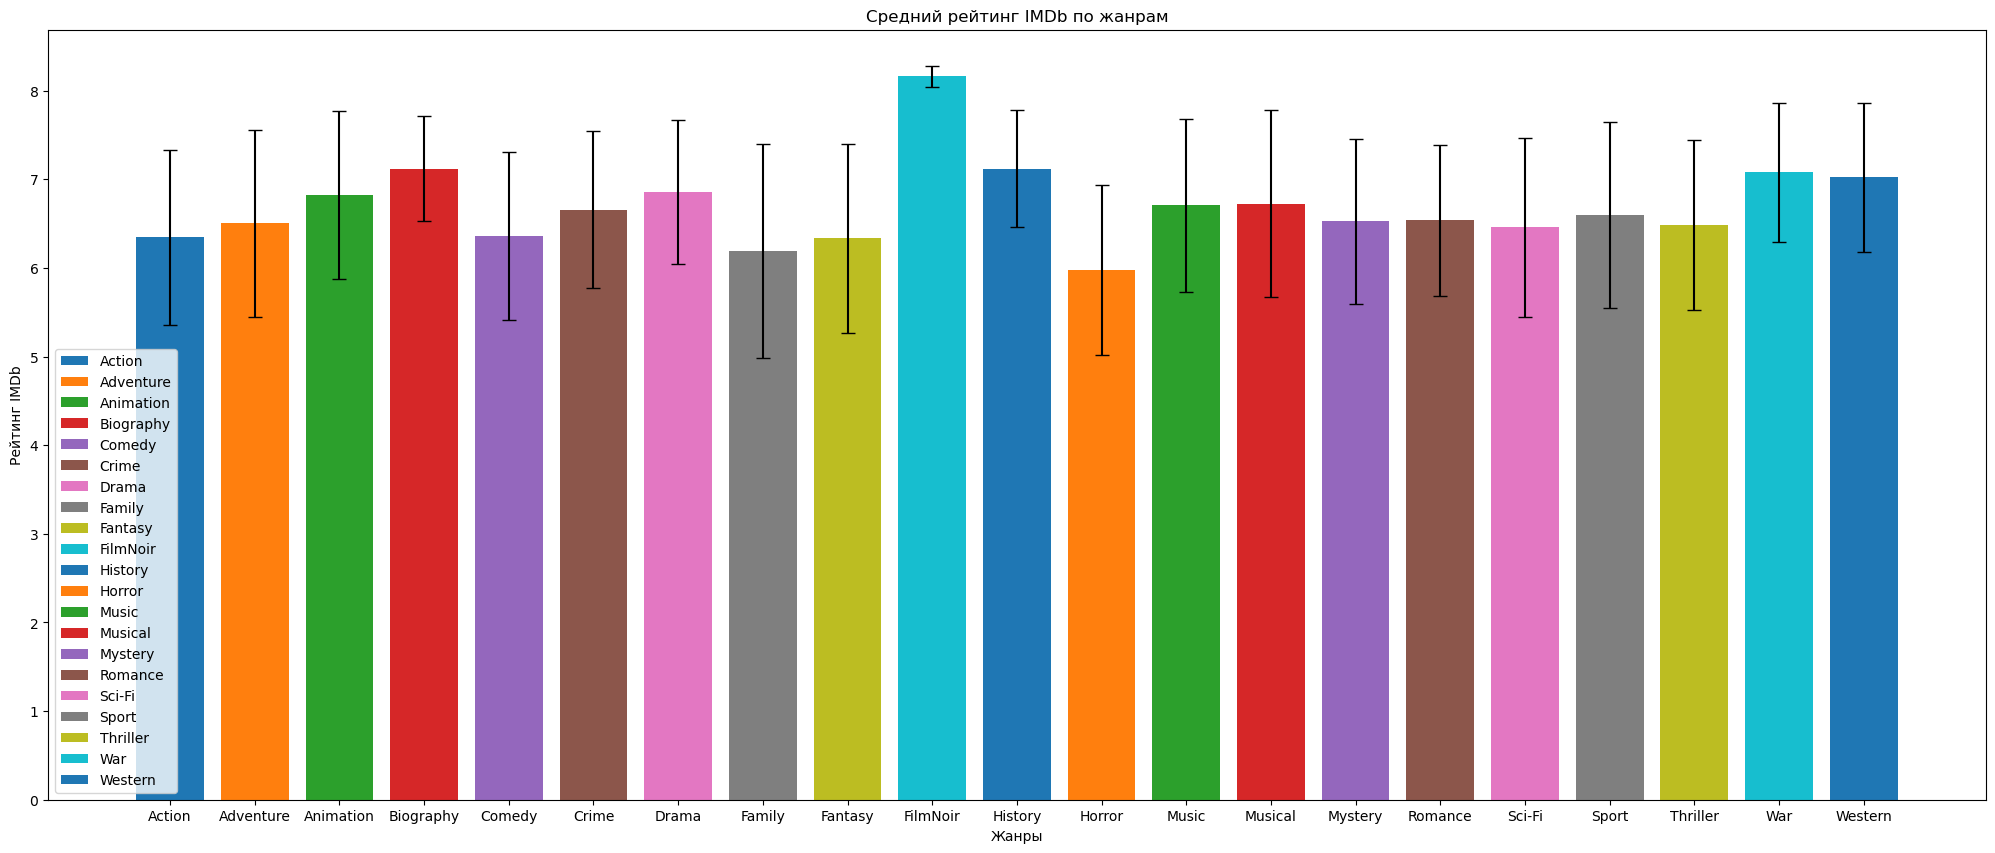

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(25, 10))
for genre in genres:
    genre_ratings = df[df['Genre'].str.contains(genre)]['Score']
    plt.bar(genre, genre_ratings.mean(), yerr=genre_ratings.std(), capsize=5, label=genre)

plt.xlabel('Жанры')
plt.ylabel('Рейтинг IMDb')
plt.title('Средний рейтинг IMDb по жанрам')
plt.legend()
plt.show()

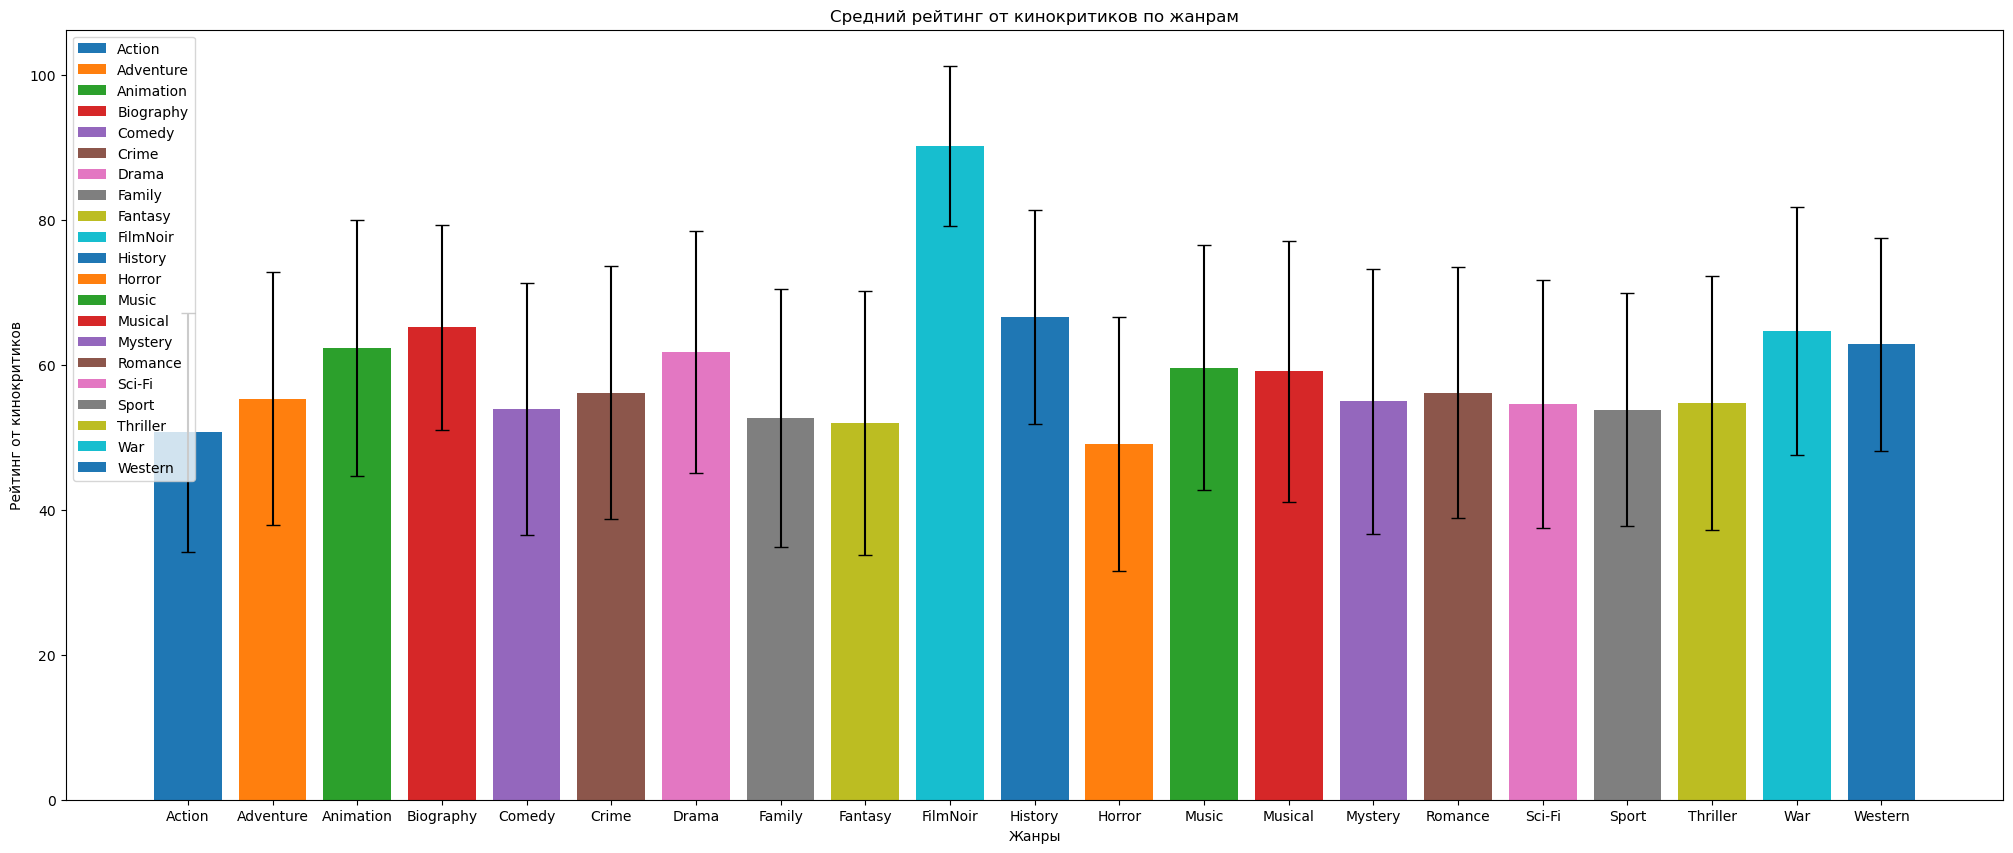

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(25, 10))
for genre in genres:
    genre_ratings = df[df['Genre'].str.contains(genre)]['Metascore']
    plt.bar(genre, genre_ratings.mean(), yerr=genre_ratings.std(), capsize=5, label=genre)

plt.xlabel('Жанры')
plt.ylabel('Рейтинг от кинокритиков')
plt.title('Средний рейтинг от кинокритиков по жанрам')
plt.legend()
plt.show()

Можно увидеть, что средние оценки от пользователей и критиков очень сильно различаются, так что пользователи обычно смотрят только те жанры, которые им интересны, поэтому их оценка субъективна, а у критиков, наоборот, есть цель посмотреть фильм вне зависимости от того, какой жанр они любят. При этом, можно заметить, что наивысшая средняя оценка у пользователей IMDb и кинокритиков принадлежит жанру Нуар(FilmNoir).

 **Построим между непрерывными признаками корреляционную матрицу, а также нарисуем её**

In [14]:
matrix = df[var_real].corr()
matrix

,Metascore,Vote,Runtime,Revenue,Year
Metascore,1.000000,0.244466,0.256692,0.074405,-0.158332
Vote,0.244466,1.000000,0.309717,0.615905,0.012928
Runtime,0.256692,0.309717,1.000000,0.220654,-0.065656
Revenue,0.074405,0.615905,0.220654,1.000000,0.026736
Year,-0.158332,0.012928,-0.065656,0.026736,1.000000


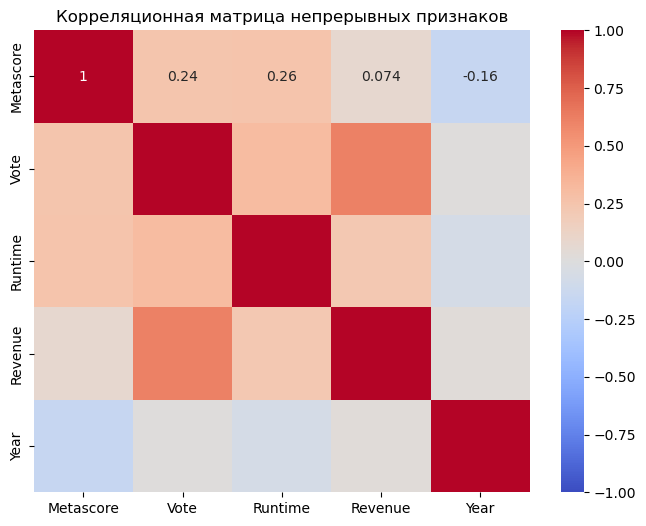

In [15]:
plt.figure(figsize=(8, 6))
sns.heatmap(matrix, annot=True, cmap='coolwarm',vmin=-1, vmax=1)
plt.title('Корреляционная матрица непрерывных признаков')
plt.show()

* `Корреляция Metascore с Vote` - 0.24. Зависимость этих переменных слабо положительная. 
* `Корреляция Metascore с Runtime` - 0.26. Здесь ситуация все прежняяя, зависимость переменных слабо положительная.
* `Корреляция Metascore с Revenue` - 0.07. Здесь присутствует слабо положительная зависимость. Нельзя сказать, что при изменение одной переменной на 1, что что-то сильно поменяется
* `Корреляция Metascore с Year` - -0.15. Зависимость между этими переменными слабо отрицательная. Измение одной переменно не влияет на изменение другой. 
* `Корреляция Vote с Runtime` - 0.31. Здесь ситуация все прежняяя, зависимость переменных слабо положительная.
* `Корреляция Vote с Revenue` - 0.62. Вот тут ситуация уже лучше, тут присутствует сильная положительная зависимость. При увелечение Vote будет меняться и Revenue. Чем больше прибыль, тем больше голосов от пользователей. 
* `Корреляция Vote с Year` -  0.01. Здесь ситуация слабой, очень незначительной, положительной корреляции.
* `Корреляция Runtime с Revenue` - 0.22. Между этими переменными существует слабо положительная корреляционная связь.
* `Корреляция Runtime с Year` - -0.07. Между этими переменными слабо отрицательная зависимость. 
* `Корреляция Revenue с Year` - 0.03. Здесь ситуация слабо положительной корреляции.рреляции.

## OHE-кодирование

**С помощью OHE-кодирования у нас появляется 21 свежий OHE-признак - это жанры фильмов. Если у фильма указан жанр, то в колонке этого жанра будет стоять 1, если этого жанра нет, то будет стоять 0.**

In [16]:
ohe_df=df['Genre'].str.get_dummies(', ')
ohe_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6125 entries, 0 to 9991
Data columns (total 21 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Action     6125 non-null   int64
 1   Adventure  6125 non-null   int64
 2   Animation  6125 non-null   int64
 3   Biography  6125 non-null   int64
 4   Comedy     6125 non-null   int64
 5   Crime      6125 non-null   int64
 6   Drama      6125 non-null   int64
 7   Family     6125 non-null   int64
 8   Fantasy    6125 non-null   int64
 9   FilmNoir   6125 non-null   int64
 10  History    6125 non-null   int64
 11  Horror     6125 non-null   int64
 12  Music      6125 non-null   int64
 13  Musical    6125 non-null   int64
 14  Mystery    6125 non-null   int64
 15  Romance    6125 non-null   int64
 16  Sci-Fi     6125 non-null   int64
 17  Sport      6125 non-null   int64
 18  Thriller   6125 non-null   int64
 19  War        6125 non-null   int64
 20  Western    6125 non-null   int64
dtypes: int64(21)
memory

**Соединяем наш датасет и свежие OHE-признаки.**

In [17]:
df_movies_ohe=pd.concat([df, ohe_df], axis=1)
df_movies_ohe

,Year,Score,Metascore,Genre,Vote,Runtime,Revenue,Action,Adventure,Animation,...,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western
0,1994,9.3,80.0,Drama,2011509,142,28.34,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2008,9.0,84.0,"Action, Crime, Drama",1980200,152,534.86,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2010,8.8,74.0,"Action, Adventure, Sci-Fi",1760209,148,292.58,1,1,0,...,0,0,0,0,0,1,0,0,0,0
3,1999,8.8,66.0,Drama,1609459,139,37.03,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1994,8.9,94.0,"Crime, Drama",1570194,154,107.93,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9975,1983,6.9,51.0,"Drama, Mystery, Music",6039,95,4.79,0,0,0,...,0,1,0,1,0,0,0,0,0,0
9976,2005,6.1,59.0,"Comedy, Drama, Music",6039,112,17.38,0,0,0,...,0,1,0,0,0,0,0,0,0,0
9982,1989,7.2,52.0,"Comedy, Drama, Romance",6035,108,6.35,0,0,0,...,0,0,0,0,1,0,0,0,0,0
9990,2012,6.8,74.0,Drama,6030,103,0.09,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**А также дропаем Genre с жанрами чччерез запятую, так как у нас уже есть удобные свежие признаки**

In [18]:
df_movies_ohe.drop('Genre', axis=1, inplace=True)
df_movies_ohe.head()

,Year,Score,Metascore,Vote,Runtime,Revenue,Action,Adventure,Animation,Biography,...,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western
0,1994,9.3,80.0,2011509,142,28.34,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2008,9.0,84.0,1980200,152,534.86,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2010,8.8,74.0,1760209,148,292.58,1,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,1999,8.8,66.0,1609459,139,37.03,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1994,8.9,94.0,1570194,154,107.93,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Шаг 4. Гипотезы

**Гипотеза 1: матожидание рейтинга IMDb жанра анимация(Animation) равно матожиданию рейтинга IMDb жанра драмa(Drama)**
Эту гипотезу мы взяли из столбчатого графика со средними рейтингами от пользователей IMDb

In [19]:
df_anim=df_movies_ohe[df_movies_ohe['Animation'] == 1]
df_dram=df_movies_ohe[df_movies_ohe['Drama'] == 1]
nx=len(df_anim['Score'])
ny=len(df_dram['Score'])

mean_x=df_anim['Score'].mean()
mean_y=df_dram['Score'].mean()

var_x=df_anim['Score'].var()
var_y=df_dram['Score'].var()

var_delta = (var_x * (nx - 1) + var_y * (ny - 1)) / (nx + ny - 2)
tt = (mean_x - mean_y) / np.sqrt(var_delta * ((1 / nx) + (1 / ny)))
tc  = sts.t.ppf(0.95, nx + ny - 2) 
print('t расчётная:', tt)
print('t критическая:', tc)
print('t расчётная меньше t критической => нулевая гипотеза не отвергается')

t расчётная: -0.6047211588075844
t критическая: 1.6452644495991913
t расчётная меньше t критической => нулевая гипотеза не отвергается


Значит, мы двигаемся в правильном направлении и гипотеза верна.

## Шаг 5. Обучение модели

**Разбиваем выборку на тренировочную и тестовую**

In [20]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df_movies_ohe, test_size = 0.2, random_state=42)
train.shape, test.shape

((4900, 27), (1225, 27))

In [21]:
y_train = train[target].to_numpy()
y_test = test[target].to_numpy()

X_train = train.drop(target, axis=1).to_numpy()
X_test = test.drop(target, axis=1).to_numpy()

feature_names = train.drop(target, axis=1).columns

In [22]:
X_train.shape, X_test.shape

((4900, 26), (1225, 26))

In [23]:
y_mean = np.mean(y_train)
y_pred_naive = np.ones(len(y_test)) * y_mean 

In [24]:
from sklearn import metrics
def print_metrics(y_test,y_pred):
    print('MAE:', "%.4f" % metrics.mean_absolute_error(y_test, y_pred))
    print('RMSE:', "%.4f" % np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print('MAPE:', "%.4f" % metrics.mean_absolute_percentage_error(y_test,y_pred))
print_metrics(y_test, y_pred_naive)

MAE: 0.7483
RMSE: 0.9597
MAPE: 0.1250


In [27]:
model_regression.coef_

array([-7.43709310e-03,  3.06800590e-02,  1.69235523e-06,  5.86551597e-03,
       -9.25417262e-04, -9.07903227e-02, -1.38045431e-01,  2.93493253e-01,
        9.45145330e-02, -1.33492387e-01,  2.06877097e-02,  1.09660668e-01,
       -2.38215460e-01, -5.57419472e-02, -1.44490240e-01, -6.75903707e-02,
       -3.32969407e-01, -5.52904579e-02, -9.75947137e-02, -3.07568593e-02,
       -6.62848953e-02, -1.20120806e-01, -6.11111274e-03, -6.67894936e-02,
        5.97329875e-02, -1.15372190e-02])

In [28]:
model_regression.intercept_

19.076427282224284

In [29]:
feature_names

Index(['Year', 'Metascore', 'Vote', 'Runtime', 'Revenue', 'Action',
       'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Drama',
       'Family', 'Fantasy', 'FilmNoir', 'History', 'Horror', 'Music',
       'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'War',
       'Western'],
      dtype='object')

**На этом наша история подходит к концу...Нас съели дедлайны и сесия..**